In [1]:
import geopandas as gpd
import geojsonio as geoio
import pandas as pd
from collections import defaultdict
from shapely.geometry import Point, Polygon
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
vancouver_all_data = gpd.read_file('VancouverAllData.geojson')
vancouver_gdf = gpd.GeoDataFrame({'population':vancouver_all_data['pop'], 'geometry':vancouver_all_data['geometry']})
vancouver_gdf = vancouver_gdf.reset_index()
vancouver_gdf['population'] = pd.to_numeric(vancouver_gdf['population'])

osm_data = pd.read_json('osm/amenities-vancouver.json.gz', lines=True, compression='gzip')
osm_data['geometry'] = list(zip(osm_data['lon'],osm_data['lat']))
osm_data['geometry'] = osm_data['geometry'].apply(Point)
osm_gdf = gpd.GeoDataFrame({'amenity':osm_data['amenity'], 'geometry':osm_data['geometry']}, geometry='geometry', crs=vancouver_gdf.crs)
vancouver_gdf['area'] = vancouver_gdf['geometry'].area
vancouver_gdf['population_density'] = vancouver_gdf['population'] / (vancouver_gdf['area'] * 1000)
vancouver_gdf
# we did this to verify that .explode and .area compute the same area 
# vancouver_gdf_explode = vancouver_gdf.explode('geometry')
# vancouver_gdf_explode
# vancouver_gdf_explode['area'] = vancouver_gdf_explode['geometry'].area
# vancouver_gdf_explode
# vancouver_gdf.max()

/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_2426/125131567.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vancouver_gdf['area'] = vancouver_gdf['geometry'].area


,index,population,geometry,area,population_density
0,0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",0.000126,48910.333782
1,1,8245,"MULTIPOLYGON (((-123.02353 49.20818, -123.0234...",0.000229,35926.018931
2,2,6949,"MULTIPOLYGON (((-123.04245 49.20549, -123.0426...",0.000239,29018.934041
3,3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",0.000097,40318.042652
4,4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",0.000095,47558.899022
...,...,...,...,...,...
484,484,3530,"MULTIPOLYGON (((-122.57911 49.17246, -122.5788...",0.000646,5462.802541
485,485,96,"MULTIPOLYGON (((-122.56953 49.17974, -122.5694...",0.000216,445.127637
486,486,6228,"MULTIPOLYGON (((-122.46134 49.16769, -122.4613...",0.007359,846.345399
487,487,4255,"MULTIPOLYGON (((-122.45998 49.07500, -122.4598...",0.000378,11259.178637


# Data Prep

In [3]:
# use spatial join to match points (osm data) and multipolygons (vancouver data)
pointInPolys = gpd.tools.sjoin(osm_gdf, vancouver_gdf, op="within", how='left')
pointInPolys
# index_right is the index of the joined multipolygon, i.e. ID of an area
# group by area and for each area, get the list of amenities located in this area
amenitiesInEachArea = pointInPolys.groupby(['index_right'])['amenity'].apply(list)
# count the number of each amenity in the area and put it into dict
amenitiesInEachArea = amenitiesInEachArea.apply(lambda x: Counter(x))
amenitiesInEachArea
vancouver_gdf['amenities'] = amenitiesInEachArea
# # split the dict column into separate columns
vancouver_gdf = pd.concat([vancouver_gdf.drop(['amenities'], axis=1), vancouver_gdf['amenities'].apply(pd.Series)], axis=1)
# # # some columns are duplicated for some reason??? (removed duplciates based on col names but need to make sure we're not dropping useful data)
vancouver_gdf = vancouver_gdf.loc[:,~vancouver_gdf.columns.duplicated()].drop([0, 'index'], axis=1).fillna(0)
vancouver_gdf

/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,population,geometry,area,population_density,shelter,post_box,bank,fast_food,restaurant,bench,...,hunting_stand,waste_transfer_station,vacuum_cleaner,lounge,EVSE,storage_rental,atm;bank,healthcare,stripclub,money_transfer
0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",0.000126,48910.333782,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8245,"MULTIPOLYGON (((-123.02353 49.20818, -123.0234...",0.000229,35926.018931,1.0,1.0,5.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6949,"MULTIPOLYGON (((-123.04245 49.20549, -123.0426...",0.000239,29018.934041,0.0,1.0,0.0,0.0,1.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",0.000097,40318.042652,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",0.000095,47558.899022,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,3530,"MULTIPOLYGON (((-122.57911 49.17246, -122.5788...",0.000646,5462.802541,1.0,0.0,0.0,1.0,12.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,96,"MULTIPOLYGON (((-122.56953 49.17974, -122.5694...",0.000216,445.127637,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
486,6228,"MULTIPOLYGON (((-122.46134 49.16769, -122.4613...",0.007359,846.345399,0.0,1.0,0.0,3.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,4255,"MULTIPOLYGON (((-122.45998 49.07500, -122.4598...",0.000378,11259.178637,0.0,0.0,0.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Scale data accroding to the amenities scoring

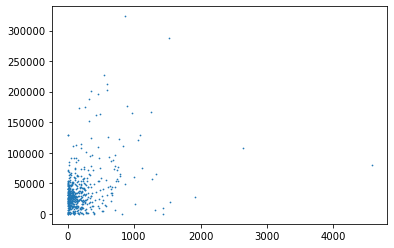

In [4]:

import json

with open("amenities_scores.txt") as f:
    data = f.read()
scores = json.loads(data)

df_train = vancouver_gdf.drop(['population', 'area', 'population_density', 'geometry'], axis=1)
# df_train += 1
scores_vector = []
for i in range(len(df_train.columns)):
    scores_vector.append(scores[df_train.columns[i]])
scores_vector

scaled_df_train = df_train * scores_vector
scaled_df_train["sum"] = scaled_df_train.sum(axis=1)
scaled_df_train['population_density'] = vancouver_gdf['population_density']
# scaled_df_train = scaled_df_train[(scaled_df_train['sum'] < 1000) & (scaled_df_train['sum'] > 50)]
scaled_df_train
plt.scatter(scaled_df_train['sum'], scaled_df_train['population_density'], 0.5)





# Machine Learning

Our x is the number of amenities of some type in the area (e.g. 2 cafes, 4 banks, etc.). Our y is the population density in this area.<br>
TO DO: Did we want to manually calculate a score for each area and use it as training data?

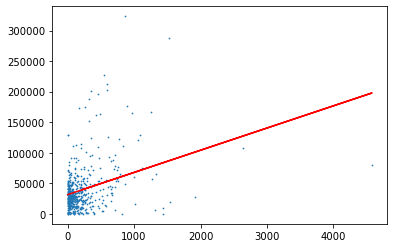

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

X = scaled_df_train["sum"].values
y = scaled_df_train['population_density'].values # divide by the area of the multipolygon 
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

X = np.stack([X], axis=1)
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
predicted_population = model.intercept_ + model.coef_[0] * X
plt.scatter(scaled_df_train["sum"], scaled_df_train['population_density'], s=0.5)
plt.plot(X, predicted_population, '-r')
predicted_population = np.moveaxis(predicted_population, 1, 0)

# scaled_df_train['predicted_population_density_difference'] = scaled_df_train["population_density"] - predicted_population[0]
# scaled_df_train

# plt.plot(X, predicted_population, '-r')

# # train model
# model = make_pipeline(
#     StandardScaler(),
#     PolynomialFeatures(degree=5, include_bias=True),
#     LinearRegression(fit_intercept=False)
#     # MLPRegressor(hidden_layer_sizes=(100, 20),
#     #                  activation='logistic', solver='lbfgs')
# )

# model.fit(np.stack([X_train], axis=1), np.stack([y_train], axis=1))
# # validate model
# print(model.score(np.stack([X_valid], axis=1), np.stack([y_valid], axis=1)))

# Heatmap

Red: overpopulated<br>
Yellow: OK<br>
Green: underpopulated<br>

if we take into account our idea of counting the amenities and predicting the population, the population distribuiton would look like the following:

In [25]:
vancouver_gdf['predicted_population_density_difference'] = scaled_df_train["population_density"] - predicted_population[0]
vancouver_gdf['percentage_difference'] = (vancouver_gdf['predicted_population_density_difference'] / vancouver_gdf['population_density']) * 100
vancouver_gdf

def getColorFromPercentage(percentage):
    if percentage < -90:
        return '#1034A6'
    elif percentage < -45:
        return '#412F88'
    elif percentage < 0:
        return '#722B6A'
    elif percentage > 90:
        return '#A2264B'
    elif percentage > 45:
        return '#D3212D'
    elif percentage >= 0:
        return '#F62D2D'


vancouver_gdf['fill'] = vancouver_gdf['percentage_difference'].apply(lambda percentage: getColorFromPercentage(percentage))
heatmap_gdf = gpd.GeoDataFrame({'geometry':vancouver_gdf['geometry'], 'fill':vancouver_gdf['fill']})
heatmap_gdf

heatmap_gdf.to_file('heatmap.geojson', driver="GeoJSON")

/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Analysis

since our model sucks, we decided to do t-test and confirm that the two vars are not related

In [39]:
from scipy import stats
# ttest = stats.ttest_ind(scaled_df_train["sum"], scaled_df_train['population_density'])
# ttest

corr = scaled_df_train["sum"].corr(scaled_df_train['population_density'])
corr

# check normality
print(stats.normaltest(scaled_df_train['population_density']).pvalue)
print(stats.normaltest(scaled_df_train["sum"]).pvalue)
# not normal, so we use non-param tests

# high sum

scaled_df_train_median_sum = scaled_df_train['sum'].median()
scaled_df_train_high_sums = scaled_df_train[scaled_df_train['sum'] > scaled_df_train_median_sum]
scaled_df_train_low_sums = scaled_df_train[scaled_df_train['sum'] <= scaled_df_train_median_sum]

print(stats.mannwhitneyu(scaled_df_train_high_sums['population_density'], scaled_df_train_low_sums['population_density']))

4.690974170543989e-73
4.3119286584947694e-126
MannwhitneyuResult(statistic=35704.0, pvalue=0.00019793370342218784)
